In [32]:
import pandas as pd
import numpy as np
import re

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime

from torch.optim.sgd import SGD
from warmup_scheduler import GradualWarmupScheduler
from sklearn.preprocessing import OneHotEncoder
import copy
import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch
# from imblearn.over_sampling import SMOTENC

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [337]:
#read raw features
X = pd.read_csv('result/X.csv')
#read labels
y = pd.read_csv('data/y.csv')
#Combine features and labels
X_y_full = pd.merge(X, y, how='left', on='full_name')

/home/junliang/venvs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [338]:
X_y_full.dtypes

full_name                  object
mirror_url                 object
archived                     bool
disabled                     bool
if_fork                      bool
size                      float64
files                     float64
stars                     float64
watches                   float64
forks                     float64
recent_commits            float64
recent_added              float64
recent_deleted            float64
recent_contributors       float64
latest_commits             object
owner_type                   bool
description                object
formats                    object
homepage                     bool
license                      bool
language                   object
commits                   float64
branches                  float64
releases                  float64
contributors              float64
topics                    float64
age                       float64
has_issues                   bool
open_issues               float64
closed_issues 

In [339]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [340]:
X.shape, y.shape

((42837, 68), (371, 2))

In [341]:
to_drop =  ['mirror_url', 'archived', 'disabled', 'if_fork'] + \
    ['full_name','description','readme', 'license_key', 'language','info', 'dependent_packages', 'formats', 
     'repositories', 'recent_added', 'recent_deleted', 'latest_commits', '_ratio']

X_y = X_y_full.drop(to_drop, axis=1)

In [342]:
# X_y = X_y.astype({'license_key': 'category'})

In [343]:
embedded_cols = {n: len(col.cat.categories) for n,col in X_y.items() if isinstance(col.dtypes, pd.CategoricalDtype)}
embedded_cols

{}

In [344]:
# for col in embedded_cols:
#     X_y[col] = LabelEncoder().fit_transform(X_y[col])

In [345]:
X = X_y.drop(['Y'], axis=1)

In [346]:
col_id = {col: i for i, col in enumerate(X.columns)}
categorical = [col_id[col] for col in embedded_cols]
numerical = [i for i in range(len(X.columns)) if i not in categorical]

In [347]:
embedded_col_names = embedded_cols.keys()
embedded_col_ids = [col_id[name] for name in embedded_cols]
n_cont = len(X.columns) - len(embedded_cols)
print('There are %d numerical columns' % n_cont)

There are 51 numerical columns


In [348]:
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

[]

In [349]:
X = X.loc[:, map(lambda col_id: X.columns[col_id], numerical + categorical)]

In [350]:
labeled = X_y['Y'].notna()
X_labeled = X.loc[labeled]
X_unlabeled = X.loc[~labeled]
y = X_y[labeled]['Y'] - 1 

In [351]:
# sm = SMOTENC(random_state=None, categorical_features=categorical)
# X_labeled, y = sm.fit_resample(X_labeled, y)

In [352]:
X_labeled_w_y = X[labeled]
dtypes = X_labeled_w_y.dtypes
columns = X_labeled_w_y.columns
dtypes

size                      float64
files                     float64
stars                     float64
watches                   float64
forks                     float64
recent_commits            float64
recent_contributors       float64
owner_type                   bool
homepage                     bool
license                      bool
commits                   float64
branches                  float64
releases                  float64
contributors              float64
topics                    float64
age                       float64
has_issues                   bool
open_issues               float64
closed_issues             float64
open_issues_recent        float64
closed_issues_recent      float64
open_prs                  float64
closed_prs                float64
open_prs_recent           float64
closed_prs_recent         float64
labels                    float64
milestones                float64
dependent_repositories    float64
people                    float64
followers     

In [363]:
X_y_unlabeled = X_y_full[~labeled]


In [365]:
book_repo = X_y_unlabeled[X_y_unlabeled['book_in_name'] | X_y_unlabeled['book_in_desc'] | X_y_full['book_phrase']]
book_repo.shape

/home/junliang/venvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(383, 69)

In [366]:
note_repo = X_y_unlabeled[X_y_unlabeled['note_in_name'] | X_y_unlabeled['note_in_desc']]
note_repo.shape

(168, 69)

In [367]:
study_repo = X_y_unlabeled.loc[X_y_unlabeled['study_in_name_desc']]
study_repo.shape

(587, 69)

In [368]:
X_y_upsampled = pd.concat([X_y_full] + [book_repo] * 5 + [note_repo] * 15 + [study_repo] * 5, ignore_index=True)

In [369]:
X_y_upsampled.shape

(50207, 69)

In [386]:
to_drop =  ['mirror_url', 'archived', 'disabled', 'if_fork'] + \
    ['full_name','description','readme', 'license_key', 'language','info', 'dependent_packages', 'formats', 
     'repositories', 'recent_added', 'recent_deleted', 'latest_commits', '_ratio']

X_y_unlabeled = X_y_upsampled.drop(to_drop, axis=1)

### Pytorch Dataset

In [329]:
pre_select = [
    [],
    [],
    ['julycoding/The-Art-Of-Programming-By-July',
      'audreyr/favicon-cheat-sheet',
      'jeffgerickson/algorithms',
      'ethereum/pm',
      'JerryLead/SparkInternals',
      'yunjey/pytorch-tutorial',
      'Taeung/git-training',
      'michaelsvit/FIAR',
      'XPila/HW',
      'panaC/libft',
      'docker/labs'
],
    
    ['megous/megatools',
     'JamesH65/GertMatrix',
     'dasfoo/rpi-gpio',
     'nchronas/Hello-C',
     'Martyn-MSys/Hello-git',
     'atrisovic/yadageexamples',
     'praveenkarthik/tutorial',
     'bakery-blueprint/whitebreadman-spring',
     'nickchen120235/notes',
     'enurod/InstaGraph',
     'ArenMarkBoghozian/Mathematics']
]

In [382]:
X_train_ = [0,0,0,0]
X_test = [0,0,0,0]
y_train_ = [0,0,0,0]
y_test = [0,0,0,0]

# num_labeled = len(y)
# test_size = int(num_labeled / 20)
# X_train_, X_test, y_train_, y_test = train_test_split(X_labeled, y, test_size=0.2)
X_y_labeled_full =  X_y_full[labeled]
X_labeled_full = X_y_labeled_full.drop(['Y'], axis=1)

# selected_index = X_labeled_full['full_name'].isin(sum(pre_select, []))
for i in range(4):
    class_i = y == i
    test_i_num = round(sum(class_i) / 5)
    addition_num = test_i_num-len(pre_select[i])
    X_labeled_i, y_labeled_i = X_labeled.loc[class_i], y[class_i]
    selected_index = X_labeled_full['full_name'].isin(pre_select[i])
    X_selected, y_selected = X_labeled_i.loc[selected_index], y_labeled_i.loc[selected_index]
    X_not_selected, y_not_selected = X_labeled_i.loc[~selected_index], y_labeled_i.loc[~selected_index]

    if addition_num > 0:
        X_train_[i], X_test[i], y_train_[i], y_test[i] = train_test_split(
            X_not_selected, y_not_selected, test_size=addition_num)
        X_test[i], y_test[i] = pd.concat((X_test[i], X_selected)), pd.concat((y_test[i], y_selected))
    else:
        X_train_[i], y_train_[i] = X_not_selected, y_not_selected
        X_test[i], y_test[i] = X_selected, y_selected

    

#     X_labeled_i, y_labeled_i = X_labeled.loc[old_class_i], y[old_class_i]
#     X_train_[i], X_test[i], y_train_[i], y_test[i] = train_test_split(X_labeled_i, y_labeled_i, test_size=test_size)
#     print(X_train_[i].shape)
#     X_train_[i] = np.concatenate([X_train_[i], X_labeled[new_class_i]])
#     print(X_train_[i].shape)
#     y_train_[i] = np.concatenate([y_train_[i], y[new_class_i]])

X_train_, X_test, y_train_, y_test = map(pd.concat, (X_train_, X_test, y_train_, y_test))
print('train shape:', X_train_.shape, 'test shape:', X_test.shape)

train shape: (280, 51) test shape: (70, 51)


In [387]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper
mapper = DataFrameMapper(
  [([X.columns[idx]], StandardScaler()) for idx in range(n_cont)] +
  [([X.columns[idx]], LabelEncoder()) for idx in range(n_cont, X.shape[1])]
)
# pipeline = Pipeline(
#   [("mapper", mapper)]
# )
X_train_ = mapper.fit_transform(X_train_)
X_test_transform = mapper.transform(X_test)
U = mapper.transform(X_unlabeled)
y_train_, y_test =  y_train_.values, y_test.values
# scaler = StandardScaler()
# scaler.fit_transform(X)
# X_train_ = scaler.fit_transform(X_train_)
# X_test = scaler.transform(X_test)
# U = scaler.transform(X_unlabeled)


In [131]:
def jackknife(model, X, y, epochs, lr, wd):
    
    n = len(X)
    
    all_samples = np.array(range(n))
    accuracy = 0

    for i in range(n):
        cur_classifier = copy.deepcopy(model)
        X_train = X[all_samples != i]
        y_train = y[all_samples != i]
        X_valid = X[all_samples == i]
        y_valid = y[all_samples == i]
        train_ds = ShelterOutcomeDataset(X_train, y_train, embedded_col_names)
        valid_ds = ShelterOutcomeDataset(X_valid, y_valid, embedded_col_names)
#         print(X_train)
        
        batch_size = 360
        train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True, drop_last=False)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True, drop_last=False)

        train_dl = DeviceDataLoader(train_dl, device)
        valid_dl = DeviceDataLoader(valid_dl, device)
        
        # model
        
        loss = train_loop(cur_classifier, train_dl, epochs=epochs, lr=lr, wd=wd)
        accuracy += val_loss(cur_classifier, valid_dl, False)[1]
    return accuracy / n

In [132]:
class GridSearchJK_CE:
    def __init__(self, model, parameters):
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
        self.model = model
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self._dfs()
        
    def _dfs(self, level=0, param_dic={}):
        if level == len(self.parameters):
            self._try_params(param_dic)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic[key] = candidate
            self._dfs(level+1, param_dic)
        
    def _try_params(self, param_dic):
        print(param_dic)
#         model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, 
#                                        dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout'])
#         model = model.double()
#         to_device(model, device)
        
        jackknife_score = jackknife(self.model, self.X, self.y, epochs=param_dic['epochs'],
                                    lr=param_dic['lr'], wd=param_dic['wd'])
        print('jackknife_score:', jackknife_score)
        if self.best_score_ < jackknife_score:
#             print(jackknife_score,param_dic)
            self.best_score_ = jackknife_score
#             self.best_estimator_ = copy.
            self.best_params_ = copy.deepcopy(param_dic)


In [388]:
class CategoryEmbeddingModel(nn.Module):
    def __init__(self, layers, n_cont, num_feature, num_class, dropout_embedding, dropout):
        super().__init__()
#         self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
#         n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
#         self.n_emb, self.n_cont = n_emb, n_cont
        self.n_cont = n_cont
        self.lin1 = nn.Linear(num_feature, layers[0])
        self.lin2 = nn.Linear(layers[0], layers[1])
        self.lin3 = nn.Linear(layers[1], num_class)
        self.bn1 = nn.BatchNorm1d(num_feature)
        self.bn2 = nn.BatchNorm1d(layers[0])
        self.bn3 = nn.BatchNorm1d(layers[1])
        self.emb_drop = nn.Dropout(dropout_embedding)
        self.drops = nn.Dropout(dropout)
        
    def forward(self, x):
        x_cat, x_cont = x[:, self.n_cont:], x[:, :self.n_cont]
#         x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
#         x = torch.cat(x, 1)
    
        x_cat = self.emb_drop(x_cat)
        x = torch.cat([x_cat, x_cont], 1)
        x = self.bn1(x)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [389]:
class Embedding(nn.Module):
    def __init__(self, embedding_sizes, n_cont,):
        super().__init__()
        self.embeddings = [nn.Embedding(categories, size) for categories,size in embedding_sizes]
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_cont = n_cont
        self.num_feature = n_emb + n_cont
        
    def forward(self, x):
        x_cat, x_cont = x[:, self.n_cont:].long(), x[:, :self.n_cont].double()
        x_cat = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        if x_cat:
            x_cat = torch.cat(x_cat, 1)
            x = torch.cat([x_cont, x_cat], 1)
        else:
            x = x_cont
        return x

In [403]:
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

def score_wrapper(parameters, data):
    def mix(x1, x2):
        alpha = parameters['alpha']
        beta = np.random.beta(alpha, alpha)

        x = beta * x1 + (1 - beta) * x2
        return x

    def mixup(uj, uk, model, embedding):
        uj, uk = map(embedding, (uj, uk))
        um = mix(uj, uk)
        yj, yk = map(model, (uj, uk))
        ym = mix(yj, yk)
        return um, ym


    def basic_generator(all_indices, iters, x, y=None, batch_size=32,):
        while(True):     
            i = 0
            all_indices = np.random.permutation(len(all_indices))
            if y is None or parameters['mixup']:
                all_indices2 = np.random.permutation(len(all_indices))

            for it in range(iters):
                if y is not None and not parameters['mixup']:
                    indices = all_indices[i:i+batch_size] 
                    yield x[indices], y[indices]

                elif y is not None and parameters['mixup']:
                    indices1 = all_indices[i:i+batch_size] 
                    indices2 = all_indices2[i:i+batch_size]
                    yield x[indices1], x[indices2], y[indices1], y[indices2]
                else:
                    indices1 = all_indices[i:i+batch_size] 
                    indices2 = all_indices2[i:i+batch_size] 
                    yield x[indices1], x[indices2]
                i += batch_size

    def batch_generator(indices, x, y, u, batch_size=32):
        
        labeled_generator = basic_generator(indices, parameters['train_iters'], x, y, batch_size)
        unlabeled_generator = basic_generator(np.random.permutation(len(u)), 
                                              parameters['train_iters'], 
                                              u, batch_size=batch_size)#*len(u)//len(indices))
        
        while(True):
            uj, uk = next(unlabeled_generator)
            if parameters['mixup']:
                xi1, xi2, yi1, yi2 = next(labeled_generator)
                yield xi1, xi2, yi1, yi2, uj, uk
            else:
                xi, yi = next(labeled_generator)  
                yield xi, yi, uj, uk

    class ICTLoss(torch.nn.Module):
        def __init__(self, lambda_u):
            super(ICTLoss, self).__init__()
            self.lambda_u = 0
            self.max_lambda_u = lambda_u
            self.xent = torch.nn.CrossEntropyLoss()
            self.mse = torch.nn.MSELoss()
            self.ramp_up = self.max_lambda_u / (parameters['epochs'] * parameters['train_iters']) * 4

        def forward(self, xi, yi, uj, uk, model, embedding, ema_model, ema_embedding):
            um = mix(*map(embedding, (uj, uk)))

            uj, uk = map(ema_embedding, (uj, uk))
            yj, yk = map(ema_model, (uj, uk))
            ym = mix(yj, yk)
            loss_consistency = self.mse(model(um), ym)

            xi = embedding(xi)
            loss_supervised = self.xent(model(xi), yi.argmax(axis=1))

            loss = loss_supervised + self.lambda_u * loss_consistency

            return loss
        
        def rampup(self):
            self.lambda_u += self.ramp_up if self.lambda_u + self.ramp_up <= self.max_lambda_u else 0

    class EMA:
        def __init__(self, alpha):
            self.alpha = alpha

        def update(self, model, ema_model, global_step):
            # Use the true average until the exponential average is more correct
            alpha = min(1 - 1 / (global_step + 1), self.alpha)
            for ema_param, param in zip(ema_model.parameters(), model.parameters()):
                ema_param.data.mul_(alpha).add_(param.data, alpha=1-alpha) 


    def test(model, embedding, test_gen):
        acc = []
        for i, (x, y) in enumerate(test_gen):
            pred = predict((model, embedding), x) #model(embedding(x)).argmax(axis=1)
            compare = pred == y.argmax(axis=1).numpy()
            acc.append(np.mean(compare))
            if i == parameters['test_iters'] - 1:
                break
        acc = np.mean(acc)
#         print('Accuracy was : {}'.format(acc))
        return acc

    def save(model, embedding, epoch):
        torch.save(model.state_dict(), 'model/model_{}.pth'.format(epoch))
        torch.save(embedding.state_dict(), 'model/embedding_{}.pth'.format(epoch))

    def get_optim(model, embedding):
        params = list(model.parameters()) + list(embedding.parameters())
#         optim = torch.optim.SGD(params, lr=10**parameters['lr_exp'], momentum=param_dic['momentum'], 
#                                 weight_decay=10**parameters['wd_exp'], nesterov=True)

    #     # scheduler_warmup is chained with schduler_steplr

        optim = torch.optim.Adam(params, lr=10**parameters['lr_exp'], weight_decay=10**parameters['wd_exp'])

        scheduler_steplr = CosineAnnealingLR(optim, T_max=parameters['epochs'] * parameters['train_iters'] + 100, eta_min=0, last_epoch=-1)
        scheduler_warmup = GradualWarmupScheduler(optim, multiplier=1, total_epoch=10*parameters['train_iters'], after_scheduler=scheduler_steplr)

        return optim, scheduler_warmup

    def train(model_list, train_gen_list, valid_gen_list, test_gen_list=None):
        k = parameters['cv_num']
        optimizer_list = []
        loss_history_list = [[] for _ in range(k)]
        ema_model_list = []
        for j in range(k): 
            model, embedding = model_list[j]
            optim, scheduler_warmup = get_optim(model, embedding)
            optimizer_list.append((optim, scheduler_warmup))
            
            ema_model = copy.deepcopy(model)
            ema_embedding = copy.deepcopy(embedding)
            ema_model_list.append((ema_model, ema_embedding))
            
            
        loss_fn = ICTLoss(parameters['lambda_u'])
        ema = EMA(parameters['ema'])
        best_acc = 0
        best_loss = 100
        best_model = None
        loss_list = []
        
        i = 0
        while 1:
            
            for j in range(k):
                model, embedding = model_list[j]
                ema_model, ema_embedding = ema_model_list[j]
                train_gen = train_gen_list[j]
                valid_gen = valid_gen_list[j]
                optim, scheduler_warmup = optimizer_list[j]
                next_train = next(train_gen)

                optim.zero_grad()
                loss = loss_fn(*next_train, model, embedding, ema_model, ema_embedding)
                loss.backward()
                optim.step()
                scheduler_warmup.step()
                ema.update(model, ema_model, i)
                ema.update(embedding, ema_embedding, i)
                loss_history_list[j].append(loss.detach().numpy())
            loss_fn.rampup()
            
            if i % parameters['train_iters'] == 0:
                epoch = i // parameters['train_iters']
                loss = np.mean(loss_history_list)
                loss_list.append(loss)
                loss_history_list = [[] for j in range(k)]

                acc = 0
                acc_test = 0
                if test_gen_list:
                    test_gen = test_gen_list[j]
                for j in range(k):
                    model, embedding = model_list[j]
                    valid_gen = valid_gen_list[j]
                    acc += test(model, embedding, valid_gen)
                    if test_gen_list:
                        acc_test += test(model, embedding, test_gen)
                    model.train(), embedding.train()
                acc /= k
                if test_gen_list:
                    acc_test /= k
                if parameters['tune']:
                    tune.report(mean_accuracy=acc, mean_loss=loss, test_acc=acc_test if test_gen_list else None)
                else:
                    print('epoch {}, acc {}, loss {}, test acc {}'.format(epoch, acc, loss, acc_test))

#                 save(model, embedding, i)
                if acc > best_acc:
                    best_acc = acc
                    best_loss = loss
                    best_model = copy.deepcopy((model, embedding))
                    best_epoch = epoch
                    for _, (x, y) in enumerate(valid_gen):
                        pred = predict((model, embedding), x)
                        break
                if epoch == parameters['epochs'] - 1:
                    return best_model
#                     print('best:\nloss: {}, acc: {}'.format(best_loss, best_acc))
#                     return best_model, best_acc, best_epoch, loss_history

            i += 1

    def make_model(embedding_sizes, n_cont):
        embedding = Embedding(embedding_sizes, n_cont,).double()
        embedding = to_device(embedding)
        model = CategoryEmbeddingModel(parameters['layers'], n_cont, embedding.num_feature, parameters['num_class'], 
                                        dropout_embedding=parameters['dropout_embedding'], dropout=parameters['dropout']).double()
        model = to_device(model)
        return model, embedding

    def score(data):
        k = parameters['cv_num']
    
        model_list = [make_model(embedding_sizes, n_cont) for i in range(k)]
        x_trn_, y_trn_, u, x_tst, y_tst = data
        num_label = len(x_trn_)
        indices = np.random.permutation(num_label)
        index_tst = np.arange(len(y_tst))
        start = 0
        train_gen_list = []
        valid_gen_list = []
        test_gen_list = []
        if k > 1:
            for i in range(k):
                index_val = indices[start: start + num_label // k]
                index_trn = indices[list(range(start)) + list(range(start + num_label // k, len(indices)))]
                train_gen_list.append(
                    batch_generator(index_trn, x_trn_.double(), y_trn_, u.double(), parameters['batch_size']))
                valid_gen_list.append(basic_generator(index_val, parameters['test_iters'], 
                                                     x_trn_.double(), y_trn_, len(index_val)))
                test_gen_list.append(basic_generator(index_val, parameters['test_iters'], 
                                                     x_tst.double(), y_tst, len(index_tst)))
                start += num_label // k
        else:
            train_gen_list = [batch_generator(indices, x_trn_.double(), y_trn_, u.double(), parameters['batch_size'])]
            valid_gen_list.append(basic_generator(index_tst, parameters['test_iters'], 
                                                     x_tst.double(), y_tst, len(y_tst)))
#             x_trn, y_trn, x_val, y_val = x_trn_[index_trn], y_trn_[index_trn], x_trn_[index_tst], y_trn_[index_tst]
#             labeled.append((x_trn, y_trn, x_val, y_val))

#         model, embedding = model
#         x_trn, y_trn, u, x_tst, y_tst = data
        
        t0 = datetime.now()
#         best_model, best_acc, best_epoch, loss_history = \
        best_model = train(model_list, train_gen_list, valid_gen_list, test_gen_list)
        t1 = datetime.now()
        print((t1 - t0).total_seconds() / 60, 'minutes')
        return best_model
#         return best_model, best_acc, best_epoch, loss_history

    def logit(model, x):
        model, embedding = model
        model.eval()
        embedding.eval()
        return model(embedding(x))

    def predict(model, x):
        return logit(model, x).argmax(axis=1).numpy()
    
    return score(data)

In [399]:
def make_data(X_train_, y_train_, U, X_test, y_test):
        x_trn, y_trn = X_train_, y_train_.reshape([-1,1])
        x_tst, y_tst = X_test, y_test.reshape([-1,1])
        #size of unlabeled is multiple of labeled 
        num_U = len(U) // len(x_trn) * len(x_trn)
        u = U[np.random.choice(list(range(len(U))), num_U ,replace=False)].astype('int')

        onehot_encoder = OneHotEncoder(sparse=False)
        y_trn, y_tst = onehot_encoder.fit_transform(y_trn), onehot_encoder.fit_transform(y_tst)
        x_trn, y_trn, u, x_tst, y_tst = to_torch(x_trn, y_trn, u, x_tst, y_tst)
        return x_trn, y_trn, u, x_tst, y_tst
    

def to_torch(*args):
    convert_fn = lambda x: torch.from_numpy(x).to(parameters['device'])
    l = list(map(convert_fn, args))
    if len(l)==1:
        l = l[0]
    return l

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data):
    """Move tensor(s) to chosen device"""
    device = parameters['device']
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def logit(model, x):
        model, embedding = model
        model.eval()
        embedding.eval()
        return model(embedding(x))
    
def predict(model, x):
        return logit(model, x).argmax(axis=1).numpy()

In [401]:
def optimize_hp(data):
    def optimize_wrapper(parameters):
        return score_wrapper(parameters=parameters, data=data)

#     algo = BayesOptSearch(parameters, metric="mean_accuracy", mode="max")
    scheduler = AsyncHyperBandScheduler(
        time_attr="training_iteration",
        metric="mean_accuracy",
        mode="max",
        grace_period=100,
        max_t=parameters['epochs'],
        
    )
    
    analysis = tune.run(
        optimize_wrapper, 
        num_samples=1 if parameters['smoke_test'] else 20, 
        name=parameters['experiment_name'],
        verbose=1,
        scheduler=scheduler if not parameters['smoke_test'] else None, 
        config=parameters, 
        resources_per_trial={'cpu':1 if not parameters['smoke_test'] else 8},
    )
    return analysis

In [ ]:
# import shutil
# shutil.rmtree('~/ray_results/optimize_wrapper')
parameters = {
    'dropout_embedding': 0,                  
    'dropout': tune.uniform(0, 0.3),
    'lr_exp': tune.uniform(-4, -2),
    'wd_exp': tune.uniform(-5, -1),
    'lambda_u': 100,
    'alpha':  tune.uniform(0, 1),
    'train_iters': 7,
    'test_iters': 1,
    'batch_size': 32,
    'cv_num':5,
    'epochs': 1600,
    'ema': 0.999,
    'momentum':0.9,
    'layers': [128, 128],
    'num_class' : 4,
    'device': 'cpu',
    'smoke_test': False,
    'mixup': False,
    'tune': True, 
    'experiment_name': 'upsample'
}

ray.shutdown()
ray.init(webui_host='0.0.0.0')
# model = make_model(embedding_sizes, n_cont, device)
data = make_data(X_train_, y_train_, U, X_test_transform, y_test)
t0= datetime.now()
analysis = optimize_hp(data)
t1 = datetime.now()
print((t1 - t0).total_seconds() / 60, 'minutes')
print("Best config is:", analysis.get_best_config(metric="mean_accuracy"))


Trial name,status,loc,alpha,dropout,lr_exp,wd_exp,acc,loss,iter,total time (s)
optimize_wrapper_16535_00000,RUNNING,38.68.38.193:5712,0.68639,0.222427,-3.18429,-1.85503,0.992857,1.81541,130,244.903
optimize_wrapper_16535_00001,TERMINATED,,0.684884,0.0320593,-3.6727,-3.44264,0.914286,2.2733,100,191.321
optimize_wrapper_16535_00002,TERMINATED,,0.276348,0.0691961,-2.65627,-4.99006,0.985714,1.34532,100,188.662
optimize_wrapper_16535_00003,RUNNING,38.68.38.193:5715,0.451833,0.0400745,-2.8423,-4.77616,0.978571,1.2339,125,242.144
optimize_wrapper_16535_00004,RUNNING,38.68.38.193:5710,0.139171,0.110334,-2.66841,-4.8888,0.978571,1.27084,133,241.219
optimize_wrapper_16535_00005,TERMINATED,,0.644175,0.214248,-3.65534,-2.55793,0.903571,3.33053,100,186.17
optimize_wrapper_16535_00006,TERMINATED,,0.169791,0.145993,-3.58307,-3.11436,0.9,3.47476,100,192.171
optimize_wrapper_16535_00007,TERMINATED,,0.812986,0.112745,-2.96935,-4.23324,0.967857,1.4731,100,188.487
optimize_wrapper_16535_00008,RUNNING,38.68.38.193:6099,0.282806,0.122923,-2.92409,-2.05887,0.95,1.62186,27,50.5505
optimize_wrapper_16535_00009,RUNNING,38.68.38.193:6102,0.215502,0.272478,-3.11521,-1.75273,0.910714,2.27811,27,51.256


In [ ]:
def hp_test(parameters, data):
    def optimize_wrapper(parameters):
        return score_wrapper(parameters=parameters, data=data)
    
    trials = tune.run(
        optimize_wrapper,
        name=parameters['experiment_name'],
        num_samples=1, 
        verbose=0,
        config=parameters, 
        resources_per_trial={'cpu':8},
        return_trials=True
    )
    return trials

In [161]:
# param_dic = analysis.get_best_config(metric="mean_accuracy") 
param_dic = copy.deepcopy(parameters)
param_dic['smoke_test'] = True
# param_dic['epochs'] = 'relabel_test'
param_dic['cv_num'] = 1
param_dic['tune'] = False
# param_dic['if_ray'] = True
param_dic.update({
    'dropout': 0.1,
    'lr_exp': -3,
    'wd_exp': -4,
    'lambda_u': 100,
    'alpha': 0.8,
})

device = param_dic['device']
# model = make_model(embedding_sizes, n_cont, device)
# data = make_data(X_train_, y_train_, U, X_test_transform, y_test, device)
ray.shutdown()
ray.init(webui_host='0.0.0.0')
t0= datetime.now()
best_model = score_wrapper(param_dic, data)

t1 = datetime.now()
print((t1 - t0).total_seconds() / 60, 'minutes')




2020-07-23 19:04:15,227	INFO resource_spec.py:212 -- Starting Ray with 16.55 GiB memory available for workers and up to 8.29 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-23 19:04:15,565	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-07-23 19:04:15,944	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-07-23 19:04:16,446	INFO services.py:1165 -- View the Ray dashboard at 38.68.38.193:8265


epoch 0, acc 0.35714285714285715, loss 1.469062064852517, test acc 0
epoch 1, acc 0.37142857142857144, loss 1.432557949252465, test acc 0
epoch 2, acc 0.4142857142857143, loss 1.5266373754596656, test acc 0
epoch 3, acc 0.4714285714285714, loss 1.551030819417701, test acc 0
epoch 4, acc 0.6, loss 1.625406958319046, test acc 0
epoch 5, acc 0.5428571428571428, loss 1.7435665244518952, test acc 0
epoch 6, acc 0.5714285714285714, loss 1.9201681021519366, test acc 0
epoch 7, acc 0.5857142857142857, loss 1.8711316331947043, test acc 0
epoch 8, acc 0.6142857142857143, loss 1.850345629583966, test acc 0
epoch 9, acc 0.6428571428571429, loss 1.7006759631884527, test acc 0
epoch 10, acc 0.6428571428571429, loss 1.74892995615259, test acc 0
epoch 11, acc 0.7285714285714285, loss 2.026010834494411, test acc 0
epoch 12, acc 0.7428571428571429, loss 1.6615141602989958, test acc 0
epoch 13, acc 0.6857142857142857, loss 1.6834622923999196, test acc 0
epoch 14, acc 0.7, loss 2.414926232498177, test acc

epoch 122, acc 0.6857142857142857, loss 2.0751742121656167, test acc 0
epoch 123, acc 0.7, loss 2.6143594046582144, test acc 0
epoch 124, acc 0.6714285714285714, loss 2.173522027073565, test acc 0
epoch 125, acc 0.7142857142857143, loss 2.071881856377164, test acc 0
epoch 126, acc 0.6571428571428571, loss 1.8828204098034906, test acc 0
epoch 127, acc 0.6571428571428571, loss 1.8827923246008598, test acc 0
epoch 128, acc 0.6714285714285714, loss 2.3542252881984713, test acc 0
epoch 129, acc 0.6714285714285714, loss 1.77039485632899, test acc 0
epoch 130, acc 0.6857142857142857, loss 2.1045889685802566, test acc 0
epoch 131, acc 0.7142857142857143, loss 2.212037568168381, test acc 0
epoch 132, acc 0.6857142857142857, loss 1.9867840225430662, test acc 0
epoch 133, acc 0.6571428571428571, loss 2.0995038210380934, test acc 0
epoch 134, acc 0.6857142857142857, loss 1.9554220302941556, test acc 0
epoch 135, acc 0.6714285714285714, loss 1.963647341100239, test acc 0
epoch 136, acc 0.6428571428

epoch 240, acc 0.6714285714285714, loss 1.8841266489598865, test acc 0
epoch 241, acc 0.6714285714285714, loss 1.9644802753368313, test acc 0
epoch 242, acc 0.6857142857142857, loss 1.934761410889921, test acc 0
epoch 243, acc 0.6714285714285714, loss 2.212060227134361, test acc 0
epoch 244, acc 0.6714285714285714, loss 1.8785583776135932, test acc 0
epoch 245, acc 0.6571428571428571, loss 2.0304923345506354, test acc 0
epoch 246, acc 0.6571428571428571, loss 1.9459211791187312, test acc 0
epoch 247, acc 0.6571428571428571, loss 2.0505110291319455, test acc 0
epoch 248, acc 0.6571428571428571, loss 2.0133982161882935, test acc 0
epoch 249, acc 0.6571428571428571, loss 2.0885169316666023, test acc 0
epoch 250, acc 0.6571428571428571, loss 2.151514082534383, test acc 0
epoch 251, acc 0.6428571428571429, loss 1.6705176424763912, test acc 0
epoch 252, acc 0.6428571428571429, loss 1.7073966604372897, test acc 0
epoch 253, acc 0.6714285714285714, loss 2.0847887057184953, test acc 0
epoch 254

epoch 357, acc 0.6857142857142857, loss 1.6784174642055798, test acc 0
epoch 358, acc 0.6857142857142857, loss 1.4717442708761983, test acc 0
epoch 359, acc 0.6857142857142857, loss 1.3832608236354162, test acc 0
epoch 360, acc 0.6714285714285714, loss 1.5111438436004754, test acc 0
epoch 361, acc 0.6857142857142857, loss 1.4415305518252755, test acc 0
epoch 362, acc 0.6428571428571429, loss 1.5109751049711762, test acc 0
epoch 363, acc 0.6857142857142857, loss 1.488380459869191, test acc 0
epoch 364, acc 0.6857142857142857, loss 1.7249555962534575, test acc 0
epoch 365, acc 0.6714285714285714, loss 1.3843631569723318, test acc 0
epoch 366, acc 0.6857142857142857, loss 1.4849770080753595, test acc 0
epoch 367, acc 0.6714285714285714, loss 1.4704050030792037, test acc 0
epoch 368, acc 0.6714285714285714, loss 1.4436126407589673, test acc 0
epoch 369, acc 0.6571428571428571, loss 1.4378633727942838, test acc 0
epoch 370, acc 0.6714285714285714, loss 1.5361510754035315, test acc 0
epoch 3

epoch 480, acc 0.6714285714285714, loss 1.299048618557239, test acc 0
epoch 481, acc 0.6857142857142857, loss 1.3186165466688526, test acc 0
epoch 482, acc 0.6857142857142857, loss 1.2824515721985459, test acc 0
epoch 483, acc 0.6857142857142857, loss 1.3067176318611522, test acc 0
epoch 484, acc 0.6857142857142857, loss 1.2614908570407783, test acc 0
epoch 485, acc 0.7, loss 1.306399696156371, test acc 0
epoch 486, acc 0.7, loss 1.3498990515846572, test acc 0
epoch 487, acc 0.6857142857142857, loss 1.446024174050826, test acc 0
epoch 488, acc 0.6857142857142857, loss 1.3092436210773362, test acc 0
epoch 489, acc 0.7, loss 1.2653144440228903, test acc 0
epoch 490, acc 0.7, loss 1.4004783134392296, test acc 0
epoch 491, acc 0.6571428571428571, loss 1.3029905122922725, test acc 0
epoch 492, acc 0.6714285714285714, loss 1.3396435364459458, test acc 0
epoch 493, acc 0.6857142857142857, loss 1.2962555879353856, test acc 0
epoch 494, acc 0.6714285714285714, loss 1.2914455013383643, test acc 

epoch 600, acc 0.7, loss 1.2300471923781302, test acc 0
epoch 601, acc 0.6571428571428571, loss 1.2419154483147472, test acc 0
epoch 602, acc 0.6714285714285714, loss 1.1522517593673278, test acc 0
epoch 603, acc 0.6857142857142857, loss 1.2454143854951933, test acc 0
epoch 604, acc 0.7, loss 1.2392538190314437, test acc 0
epoch 605, acc 0.6857142857142857, loss 1.1542166535797216, test acc 0
epoch 606, acc 0.6714285714285714, loss 1.2729616810652742, test acc 0
epoch 607, acc 0.7, loss 1.2448702062262587, test acc 0
epoch 608, acc 0.6714285714285714, loss 1.257613323361508, test acc 0
epoch 609, acc 0.6714285714285714, loss 1.2242463175634204, test acc 0
epoch 610, acc 0.6714285714285714, loss 1.2397165253031606, test acc 0
epoch 611, acc 0.6714285714285714, loss 1.290006035700943, test acc 0
epoch 612, acc 0.6714285714285714, loss 1.2213751792426317, test acc 0
epoch 613, acc 0.7, loss 1.1925571321796802, test acc 0
epoch 614, acc 0.7, loss 1.1781205109742687, test acc 0
epoch 615, a

epoch 723, acc 0.6857142857142857, loss 1.1087315866373892, test acc 0
epoch 724, acc 0.6714285714285714, loss 1.259388706996706, test acc 0
epoch 725, acc 0.6714285714285714, loss 1.1743886413619324, test acc 0
epoch 726, acc 0.6857142857142857, loss 1.1165707666820952, test acc 0
epoch 727, acc 0.6857142857142857, loss 1.1939796177520046, test acc 0
epoch 728, acc 0.6857142857142857, loss 1.1762762244239695, test acc 0
epoch 729, acc 0.6857142857142857, loss 1.1816328481125484, test acc 0
epoch 730, acc 0.6714285714285714, loss 1.1139157726670545, test acc 0
epoch 731, acc 0.6714285714285714, loss 1.1337787846193301, test acc 0
epoch 732, acc 0.6857142857142857, loss 1.1422617680333107, test acc 0
epoch 733, acc 0.6857142857142857, loss 1.1601695838166375, test acc 0
epoch 734, acc 0.6714285714285714, loss 1.3181151441932022, test acc 0
epoch 735, acc 0.7, loss 1.2058634930061303, test acc 0
epoch 736, acc 0.6857142857142857, loss 1.2456936107051626, test acc 0
epoch 737, acc 0.68571

epoch 847, acc 0.6857142857142857, loss 1.1328576030011352, test acc 0
epoch 848, acc 0.6714285714285714, loss 1.1299573375884593, test acc 0
epoch 849, acc 0.6714285714285714, loss 1.0668841054907, test acc 0
epoch 850, acc 0.6857142857142857, loss 1.1349291162123794, test acc 0
epoch 851, acc 0.6857142857142857, loss 1.191330744086093, test acc 0
epoch 852, acc 0.7, loss 1.1620331599087736, test acc 0
epoch 853, acc 0.6857142857142857, loss 1.2138858823611371, test acc 0
epoch 854, acc 0.6714285714285714, loss 1.1404148692193068, test acc 0
epoch 855, acc 0.6857142857142857, loss 1.1798684864273439, test acc 0
epoch 856, acc 0.7, loss 1.1585142153613466, test acc 0
epoch 857, acc 0.6571428571428571, loss 1.163389556937618, test acc 0
epoch 858, acc 0.6857142857142857, loss 1.1639158366460474, test acc 0
epoch 859, acc 0.6857142857142857, loss 1.133407975357479, test acc 0
epoch 860, acc 0.6714285714285714, loss 1.1508457197736774, test acc 0
epoch 861, acc 0.6857142857142857, loss 1.

epoch 969, acc 0.6714285714285714, loss 1.1550689978463533, test acc 0
epoch 970, acc 0.6571428571428571, loss 1.1000086184383648, test acc 0
epoch 971, acc 0.6714285714285714, loss 1.1817150487977373, test acc 0
epoch 972, acc 0.6857142857142857, loss 1.0996931359621518, test acc 0
epoch 973, acc 0.6857142857142857, loss 1.1119282834487072, test acc 0
epoch 974, acc 0.7, loss 1.181363816412484, test acc 0
epoch 975, acc 0.6571428571428571, loss 1.1236423648415765, test acc 0
epoch 976, acc 0.7, loss 1.1263237576049747, test acc 0
epoch 977, acc 0.6857142857142857, loss 1.1906833201175626, test acc 0
epoch 978, acc 0.6714285714285714, loss 1.1930706445886876, test acc 0
epoch 979, acc 0.6714285714285714, loss 1.190749171088893, test acc 0
epoch 980, acc 0.6857142857142857, loss 1.1376066203084545, test acc 0
epoch 981, acc 0.6857142857142857, loss 1.1198250275349524, test acc 0
epoch 982, acc 0.6857142857142857, loss 1.1432700063235066, test acc 0
epoch 983, acc 0.6857142857142857, los

0.7428571428571429 0.7322832722832722 0.7341880341880342 0.7438286351329829

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84        23
         1.0       0.73      0.52      0.61        21
         2.0       0.69      0.69      0.69        13
         3.0       0.73      0.85      0.79        13

    accuracy                           0.74        70
   macro avg       0.73      0.74      0.73        70
weighted avg       0.74      0.74      0.73        70


Confusion matrix:
    0   1  2   3
0  21   2  0   0
1   5  11  2   3
2   1   2  9   1
3   0   0  2  11



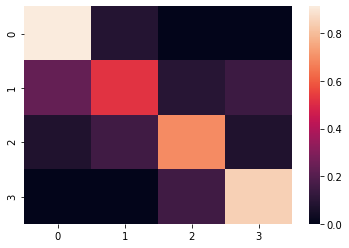

In [163]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report
from sklearn.metrics import fbeta_score, precision_recall_fscore_support

predictions = predict(best_model, (torch.tensor(X_test_transform)))
true_labels = y_test

eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels, predictions, average='macro', beta=1)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

print(eval_accuracy, fbeta, precision, recall)

# tags_vals = {i+1:i for i in range(4) }
# pred_tags = [tags_vals[p] for p in predictions]
# valid_tags = [tags_vals[l] for l in true_labels]
# counts = [valid_tags.count(tag) for tag in tags_vals]
cfs_mat = confusion_matrix(true_labels, predictions,)
cfs_with_index = pd.DataFrame(cfs_mat, )
cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, )

# print('test counts:')
# print(pd.DataFrame(tags_vals,counts))
print('')
print(classification_report(true_labels, predictions))
print('')
print('Confusion matrix:')
print(cfs_with_index)
sns.heatmap(cfs_with_index_norm)
print('')

In [160]:
X_y_full.loc[X_test[(true_labels == 1) & (predictions == 3)].index]

,full_name,mirror_url,archived,disabled,if_fork,size,files,stars,watches,forks,recent_commits,recent_added,recent_deleted,recent_contributors,latest_commits,owner_type,description,formats,homepage,license,language,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,dependent_repositories,dependent_packages,repositories,people,followers,readme,info,license_key,google,h2,links,words,book_in_name,book_in_desc,book_phrase,note_in_name,note_in_desc,study_in_name_desc,md_ratio,txt_ratio,epub_ratio,_ratio,pic_ratio,docu_ratio,code_ratio,recent_changed,latest_commits_num,latest_commits_avg,latest_commits_min,Y
219,msikma/liballeg.4.4.2-osx,NaN,False,False,False,1997.0,192.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,"[982, 1368]",False,Mac OS X build for Allegro (liballeg.4.4.2.dyl...,"{'pcx': 3, '': 75, 'dat': 4, 'txt': 1, 'ini': ...",False,False,C,5.0,1.0,1.0,1.0,0.0,1355.0,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,124.0,0.0,48.0,# Allegro 4.4.2 build for OSXþþThis is a build...,NaN,none,False,3,6,949,False,False,False,False,False,False,0.005208,0.005208,0.0,0.390625,0.000000,0.00000,0.598958,0.0,2,1175.000000,982,2.0
135,Estwald/PSDK3v2,NaN,False,False,False,333582.0,1212.0,28.0,7.0,20.0,0.0,0.0,0.0,0.0,"[2381, 2683, 2693, 2694]",False,Homebrew PS3 SDK under MinGW/Win32 based in t...,"{'7z': 2, 'md': 5, '': 141, 'bat': 10, 'c': 31...",False,False,C,17.0,1.0,0.0,1.0,0.0,2681.0,True,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,30.0,PSDK3 v2þ========þþBasado en el trabajo de Est...,NaN,none,False,2,0,549,False,False,False,False,False,False,0.004125,0.008251,0.0,0.116337,0.000825,0.00000,0.870462,0.0,4,2612.750000,2381,2.0
253,kuro68k/Retro-Adapter,NaN,False,False,False,16381.0,316.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,[1247],False,Retro Adapter V2,"{'txt': 61, '': 16, 'html': 4, 'gif': 9, 'jpg'...",False,False,C,3.0,1.0,0.0,1.0,0.0,1234.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,49.0,0.0,3.0,# Retro-AdapterþRetro Adapter V2þþConnect vari...,NaN,none,False,0,1,18,False,False,False,False,False,False,0.003165,0.193038,0.0,0.050633,0.069620,0.03481,0.648734,0.0,1,1247.000000,1247,2.0
128,DeXP/xkb-switch-win,NaN,False,False,False,196.0,15.0,15.0,1.0,1.0,0.0,0.0,0.0,0.0,"[2553, 2643, 2644, 2645, 2646, 2647]",False,xkb-switch-lib API port to Win32/Win64,"{'md': 1, 'dll': 2, 'bat': 1, 'exe': 2, 'txt':...",False,False,C,16.0,1.0,1.0,1.0,0.0,2634.0,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,30.0,0.0,26.0,xkb-switch-winþ==============þþxkb-switch-lib ...,NaN,none,False,3,6,243,False,False,False,False,False,False,0.066667,0.133333,0.0,0.000000,0.000000,0.00000,0.800000,0.0,6,2629.666667,2553,2.0
117,macks22/comdetect,NaN,False,False,False,480.0,33.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,"[1957, 1958, 1959]",False,Community detection algorithm implementations.,"{'': 2, 'md': 1, 'txt': 7, 'h': 6, 'c': 12, 's...",False,False,C,97.0,2.0,0.0,2.0,0.0,1958.0,True,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,41.0,0.0,28.0,# comdetectþCommunity detection algorithm impl...,NaN,none,False,0,0,9,False,False,False,False,False,False,0.030303,0.212121,0.0,0.060606,0.000000,0.00000,0.696970,0.0,3,1958.000000,1957,2.0


In [ ]:
X_y_full.loc[X_y_full['full_name']=='enurod/InstaGraph']

In [ ]:
X_y_full.loc[X_y_full['Y'] == 3]

In [ ]:
X_y_full['latest_commits']=X_y_full['latest_commits'].apply(eval)

In [ ]:
X_y_full[(X_y_full['Y']==1) & (X_y_full['latest_commits_num']==1)]

# Remember to change the scheme to get latest/recent commits/contributors 

In [ ]:
class GridSearchCV:
    def __init__(self, model, parameters, score):
        self.model = model
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
#         self.model = model
        self.score = score
        
    def fit(self, data):
        self.data = data
        self._dfs(param_dic_=param_dic)
        
    def _dfs(self, level=0, param_dic_={}):
        if level == len(self.parameters):
            self._try_params(param_dic_)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic_[key] = candidate
            self._dfs(level+1, param_dic_)
        
    def _try_params(self, param_dic_):
        print(param_dic_)
        k = 5
        result = []
        x_trn_, y_trn_, u = copy.deepcopy(self.data)
        num_label = len(x_trn_)
        indices = np.random.permutation(num_label)
        start = 0
        for i in range(k):
            index_tst = indices[start: start + num_label // k]
            index_trn = indices[list(range(start)) + list(range(start + num_label // k, len(indices)))]
            x_trn, y_trn, x_val, y_val = x_trn_[index_trn], y_trn_[index_trn], x_trn_[index_tst], y_trn_[index_tst]
            data = x_trn, y_trn, u, x_val, y_val
            model = copy.deepcopy(self.model)
            best_model, best_acc, best_epoch, loss_history = self.score(model, data)
            result.append(best_acc)
            start += num_label // k
        score = sum(result) / k
        print('CV Accuracy:', score)
        
        tune.report(mean_accuracy=score)
        if self.best_score_ < score:
#             print(jackknife_score,param_dic)
            self.best_score_ = score
#             self.best_estimator_ = copy.
            self.best_params_ = copy.deepcopy(param_dic_)
            self.best_history = loss_history[:]
            self.best_epoch = best_epoch


In [ ]:
def get_augmenter(): 
    def augment(x):
        return x
    return augment

def sharpen(x, T):
    temp = x**(1/T)
    return temp / temp.sum(axis=1, keepdims=True)
    
def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, alpha)
    
    x = beta * x1 + (1 - beta) * x2
    y = beta * y1 + (1 - beta) * y2
    return x, y

def mixmatch(x, y, u, model, embedding, augment_fn, T=0.5, K=1, alpha=0.75):
    xb = embedding(x)
    ub = [embedding(u) for _ in range(K)]
    qb = sharpen(sum(map(lambda i: model(i), ub)) / K, T)
    Ux = torch.cat(ub, axis=0)
    Uy = torch.cat([qb for _ in range(K)], axis=0)
    indices = np.arange(len(xb) + len(Ux))
    np.random.shuffle(indices)
#     print(xb.shape, ub.shape, qb.shape,y.shape)
    Wx = torch.cat([Ux, xb], axis=0)[indices]
    Wy = torch.cat([Uy, y], axis=0)[indices]
    X, p = mixup(xb, Wx[:len(xb)], y, Wy[:len(xb)], alpha)
    U, q = mixup(Ux, Wx[len(xb):], Uy, Wy[len(xb):], alpha)
    return X, U, p, q

class MixMatchLoss(torch.nn.Module):
    def __init__(self, max_lambda_u=100):
        super(MixMatchLoss, self).__init__()
        self.lambda_u = 0#max_lambda_u
        self.max_lambda_u = max_lambda_u
        self.xent = torch.nn.CrossEntropyLoss()
        self.mse = torch.nn.MSELoss()
#         super(MixMatchLoss, self).__init__()
    
    def forward(self, X, U, p, q, model, embedding, train_iters):
        X_ = torch.cat([X, U], axis=0)
        preds = model(X_)
        loss = self.xent(preds[:len(p)], p.argmax(axis=1)) + \
                                    self.lambda_u * self.mse(preds[len(p):], q)
        ramp_up = self.max_lambda_u / (param_dic['epochs'] * train_iters) * 3
        self.lambda_u += ramp_up if self.lambda_u + ramp_up < self.max_lambda_u else 0
        
        return loss


In [2202]:
def basic_generator(x, y=None, batch_size=32, shuffle=True):
    i = 0
    all_indices = np.arange(len(x))
    if shuffle:
        np.random.shuffle(all_indices)  
    while(True):
        indices = all_indices[i:i+batch_size]
        if y is not None:
            yield x[indices], y[indices]
        else:
            yield x[indices]
        i = (i + batch_size) % len(x)
        


In [2201]:
def mixmatch_wrapper(x, y, u, model, embedding, batch_size=32):
    augment_fn = get_augmenter()
    train_generator = basic_generator(x, y, batch_size)
    unlabeled_generator = basic_generator(u, batch_size=batch_size)
    while(True):
        xi, yi = next(train_generator)
        ui = next(unlabeled_generator)
        yield mixmatch(xi, yi, ui, model, embedding, augment_fn, alpha=param_dic['alpha'])

In [2200]:
def to_torch(*args, device=device):
    convert_fn = lambda x: torch.from_numpy(x).to(device)
    l = list(map(convert_fn, args))
    if len(l)==1:
        l = l[0]
    return l

def test(model, embedding, test_gen, test_iters):
    acc = []
    for i, (x, y) in enumerate(test_gen):
#         x = to_torch(x)
        pred = model(embedding(x)).argmax(axis=1)
        compare = pred == y.argmax(axis=1)
        acc.append(np.mean(compare.detach().numpy()))
        if i == test_iters:
            break
    print('Accuracy was : {}'.format(np.mean(acc)))

def report(iters, train_iters, loss_history):
    print('Average loss in {}th epoch was : {}'.format(iters // train_iters, np.mean(loss_history)))
    return []

def save(model, embedding, iters, train_iters):
    torch.save(model.state_dict(), 'model/model_{}.pth'.format(iters // train_iters))
    torch.save(embedding.state_dict(), 'model/embedding_{}.pth'.format(iters // train_iters))

In [2196]:
def run(model, embedding, train_gen, test_gen, epochs, train_iters, test_iters, device):
    optim, scheduler_warmup = get_optim(train_iters)
    loss_fn = MixMatchLoss()
    loss_history = []
    for i, (x, u, p, q) in enumerate(train_gen):
        scheduler_warmup.step()
        if i % train_iters == 0:
            loss_history = report(i, train_iters,loss_history)
            test(model, embedding, test_gen, test_iters)
            save(model, embedding, i, train_iters)
            print(optim.param_groups[0]['lr'])
            if i // train_iters == epochs:
                return
        
        optim.zero_grad()
        loss = loss_fn(x, u, p, q, model, embedding, train_iters)
        loss.backward()
        optim.step()
        loss_history.append(loss.detach().numpy())

In [458]:
from torch.optim.sgd import SGD
from warmup_scheduler import GradualWarmupScheduler

param_dic = {
    'dropout_embedding': 0.1,                  
     'dropout': 0.1,
     'epochs': 290,
     'lr': 1e-3,
     'wd': 1e-4,
    'lambda_u': 75,
    'alpha':0.75,
    'momentum':0.9,
}
embedding = Embedding(embedding_sizes, n_cont,).double()
embedding = to_device(embedding, device)

model = CategoryEmbeddingModel(layers, n_cont, embedding.num_feature, num_class, 
                                dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout']).double()
model = to_device(model, device)

onehot_encoder = OneHotEncoder(sparse=False)

y_trn = onehot_encoder.fit_transform(y_trn)
x_trn, y_trn, u, x_tst, y_tst = X_train_, y_train_.values.reshape([-1,1]), \
            U[np.random.choice(list(range(len(U))), 6032, replace=False)].astype('int'), X_test, y_test.values.reshape([-1,1])
y_trn, y_tst = onehot_encoder.fit_transform(y_trn), onehot_encoder.fit_transform(y_tst)
x_trn, y_trn, u, x_tst, y_tst = to_torch(x_trn, y_trn, u, x_tst, y_tst, device=device)

train_gen = mixmatch_wrapper(x_trn.double(), y_trn, u.double(), model, embedding, 208)
test_gen = basic_generator(x_tst.double(), y_tst, 52)
t0 = datetime.datetime.now()
run(model, embedding, train_gen, test_gen, param_dic['epochs'], 29, 1, device=device)
t1 = datetime.datetime.now()
print((t1 - t0).total_seconds() / 60, 'minutes')

NameError: name 'layers' is not defined

In [360]:
X = pd.get_dummies(X_labeled, columns=['license_key'])
# X_labeled.head()

In [361]:
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

#jackknife
# X_train, y_train = X, y

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 208 observation with 54 features
test data has 52 observation with 54 features


In [363]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2035]:
#title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [1581]:
# Use 5-fold Cross Validation to get the accuracy for different models
import copy
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

# for classifier in model_list:
#     cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=1)
#     print(cv_score)
#     print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
#     count += 1
    
# Train the model



def jackknife_(classifier, X, y):
    
    n = len(X)
    all_samples = np.array(range(n))
    accuracy = 0
    for i in range(n):
        cur_classifier = copy.deepcopy(classifier)
        X_train = X[all_samples != i]
        y_train = y[all_samples != i]
        X_test = X[all_samples == i]
        y_test = y[all_samples == i]
        cur_classifier.fit(X_train, y_train)
        accuracy += cur_classifier.score(X_test, y_test)
    return accuracy / n

for classifier in model_list:
    jackknife_score = jackknife_(classifier, X_train_, y_train_)
    print(jackknife_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],jackknife_score.mean()))
    count += 1
        
    

0.7135922330097088
Model accuracy of Logistic Regression is: 0.714
0.6941747572815534
Model accuracy of KNN is: 0.694
0.7669902912621359
Model accuracy of Random Forest is: 0.767


In [2110]:
# parameters = {
#     'n_estimators' : [60,80,100],
#     'min_samples_split' : [2,3,4,5,6],
#     'min_samples_leaf' : [1,2],
# }
class GridSearchJK:
    def __init__(self, classifier, parameters):
        self.classifier = classifier
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self._dfs()
        
        
    def _dfs(self, level=0, param_dic={}):
        if level == len(self.parameters):
            self._try_params(param_dic)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic[key] = candidate
            self._dfs(level+1, param_dic)
        
    def _try_params(self, param_dic):
        classifier = copy.deepcopy(self.classifier)
        classifier.set_params(**param_dic)
        jackknife_score = jackknife_(classifier, self.X, self.y)
        if self.best_score_ < jackknife_score:
            print(jackknife_score,param_dic)
            self.best_score_ = jackknife_score
            self.best_estimator_ = classifier.fit(self.X, self.y)
            self.best_params_ = copy.deepcopy(param_dic)


In [2081]:
parameters = {
    'n_estimators' : [60],
    'min_samples_split' : [3],
    'min_samples_leaf' : [2],
}
Grid_RF = GridSearchJK(RandomForestClassifier(),parameters)
Grid_RF.fit(x_trn,y_trn.argmax(axis=1))

0.7669902912621359 {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 2}


In [2082]:
print_grid_search_metrics(Grid_RF)

Best score: 0.767
Best parameters set:
	min_samples_leaf: 2
	min_samples_split: 3
	n_estimators: 60


In [2083]:
# best random forest
best_RF_model = Grid_RF.best_estimator_
best_RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [1219]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [2095]:
LR = LogisticRegression(C=0.1)
LR.fit(x_trn, y_trn.argmax(axis=1))

LogisticRegression(C=0.1)

In [2096]:
y_pred = LR.predict(x_tst)

In [2108]:
np.mean(y_pred==y_tst.argmax(axis=1).detach().numpy())

0.7407407407407407

In [2111]:

parameters = {
#     'penalty':('l1', 'l2'), 
    'C':(0.01, 0.03,0.1,0.3)
}
Grid_LR = GridSearchJK(LogisticRegression(),{'C':(0.01, 0.03,0.1,0.3)})
Grid_LR.fit(X_train_, y_train_)

0.7087378640776699 {'C': 0.01}
0.7184466019417476 {'C': 0.03}


In [1562]:
y_train_.shape

(206,)

In [1253]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.770
Best parameters set:
	C: 0.3


In [2112]:
# best model
best_LR_model = Grid_LR.best_estimator_

In [2115]:
predictions = best_LR_model.predict(X_test)
true_labels = y_test

In [2116]:
eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels, predictions, average='macro', beta=1)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

print(eval_accuracy, fbeta, precision, recall)

0.7407407407407407 0.6958866437821813 0.803453947368421 0.7208333333333334


In [1225]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'min_samples_split' : [2,3,4,5,6],
    'min_samples_leaf' : [1,2],
}
Grid_RF_ = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF_.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [60, 80, 100]})

In [1226]:
# best number of tress
print_grid_search_metrics(Grid_RF_)

Best score: 0.839
Best parameters set:
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 80


In [1227]:
# best random forest
best_RF_model_ = Grid_RF_.best_estimator_

In [1257]:
parameters

{'C': [0.01, 0.03, 0.1, 0.3]}

In [1259]:
parameters = {
#     'penalty':('l1', 'l2'), 
    'C':[0.01, 0.03,0.1,0.3]
}
LR = LogisticRegression()
Grid_LR_ = GridSearchJK(LR, parameters)
Grid_LR_.fit(X_train, y_train)

print_grid_search_metrics(Grid_LR_)

0.7130434782608696 {'C': 0.01}
0.7391304347826086 {'C': 0.03}
0.7739130434782608 {'C': 0.1}
Best score: 0.774
Best parameters set:
	C: 0.1


In [1243]:
predictions_ = best_RF_model_.predict(X_test)
true_labels_ = y_test

In [1244]:
eval_accuracy = accuracy_score(true_labels_, predictions_, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels_, predictions_, average='macro', beta=1)
precision = precision_score(true_labels_, predictions_, average='macro')
recall = recall_score(true_labels_, predictions_, average='macro')

print(eval_accuracy, fbeta, precision, recall)

0.8888888888888888 0.880266836709668 0.899621212121212 0.8829818111455108


In [763]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.741
precision is: 0.769
recall is: 0.714


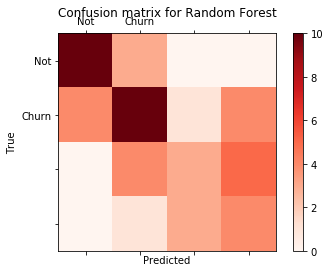

Logistic Regression
Accuracy is: 0.609
precision is: 1.000
recall is: 0.182


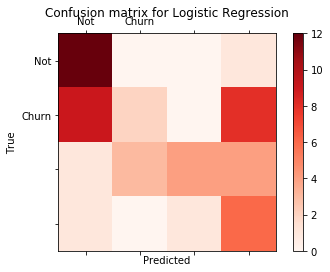

In [764]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report
from sklearn.metrics import fbeta_score, precision_recall_fscore_support

eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels, predictions, average='macro', beta=1)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

pred_tags = [tags_vals[p] for p in predictions]
valid_tags = [tags_vals[l] for l in true_labels]
counts = [valid_tags.count(tag) for tag in tags_vals]
cfs_mat = confusion_matrix(valid_tags, pred_tags,tags_vals)
cfs_with_index = pd.DataFrame(cfs_mat, index = tags_vals,
              columns = tags_vals)
cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, index = tags_vals,
              columns = tags_vals)
classification_report(valid_tags, pred_tags)

In [654]:
#Combine features and labels
data = pd.merge(features, labels, how='left', on='full_name')

In [656]:
to_drop = ['full_name','description','readme','info']
data = data.drop(to_drop, axis=1)

In [657]:
data

,size,stars,watches,forks,owner_type,if_fork,homepage,license,files,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,google,h2,links,words,book,hello,hw,Y
0,27451.0,19190.0,1906.0,7003.0,False,False,False,False,3.0,3633.0,1.0,0.0,99.0,0.0,2373.0,True,45.0,82.0,0.0,0.0,22.0,320.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0,9,55,1284,8,0,0,3
1,8034.0,26702.0,1218.0,6964.0,True,False,False,True,32.0,2584.0,6.0,78.0,40.0,6.0,2567.0,True,2436.0,2418.0,97.0,20.0,49.0,140.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,25.0,0.0,1,11,27,1197,0,0,2,1
2,6848.0,17135.0,305.0,1020.0,False,False,True,True,29.0,1323.0,16.0,11.0,112.0,0.0,2887.0,True,499.0,1169.0,60.0,22.0,89.0,385.0,19.0,12.0,34.0,5.0,7.0,11.0,63.0,51.0,0.0,0.0,45.0,0.0,575.0,0,0,15,498,0,0,0,1
3,2396.0,20383.0,430.0,1193.0,False,False,True,True,22.0,2021.0,55.0,49.0,189.0,6.0,3129.0,True,354.0,390.0,18.0,8.0,112.0,531.0,12.0,2.0,2.0,1.0,3.0,3.0,28.0,4.0,0.0,0.0,66.0,0.0,1.0,0,6,31,1039,0,0,0,1
4,8496.0,10153.0,737.0,2798.0,True,False,True,True,86.0,1697.0,5.0,96.0,156.0,0.0,6227.0,True,36.0,277.0,13.0,32.0,10.0,362.0,7.0,43.0,9.0,1.0,11.0,88.0,2864.0,1405.0,0.0,0.0,5.0,5.0,0.0,0,6,9,266,0,0,0,1
5,80841.0,13979.0,514.0,4609.0,True,False,True,True,35.0,23207.0,23.0,172.0,931.0,2.0,6752.0,True,1931.0,6672.0,324.0,354.0,257.0,7715.0,100.0,694.0,82.0,3.0,32.0,648.0,36144.0,21505.0,394799.0,23614.0,19.0,28.0,0.0,0,1,16,302,0,0,0,1
6,12127.0,13221.0,575.0,1082.0,False,False,False,False,12.0,1712.0,1.0,0.0,100.0,6.0,1929.0,True,208.0,451.0,0.0,0.0,31.0,249.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,511.0,0,12,26,1249,0,0,0,1
7,141137.0,32941.0,2191.0,19265.0,True,False,False,True,464.0,59611.0,5.0,772.0,1373.0,2.0,5546.0,False,0.0,0.0,0.0,0.0,32.0,682.0,25.0,82.0,4.0,0.0,33.0,780.0,82077.0,62162.0,0.0,0.0,7.0,17.0,0.0,0,0,5,510,0,0,0,1
8,23803.0,12243.0,392.0,1143.0,True,False,True,True,25.0,7718.0,39.0,59.0,152.0,0.0,1967.0,True,41.0,673.0,28.0,72.0,10.0,1471.0,8.0,165.0,25.0,0.0,17.0,283.0,18578.0,14330.0,0.0,0.0,125.0,168.0,0.0,0,6,24,1427,0,0,0,1
9,53431.0,7463.0,413.0,1935.0,True,False,True,True,25.0,13261.0,101.0,83.0,395.0,3.0,4243.0,True,236.0,1422.0,45.0,39.0,88.0,3794.0,28.0,102.0,16.0,2.0,9.0,242.0,7061.0,5920.0,0.0,0.0,21.0,37.0,0.0,0,8,64,2263,0,0,0,1


In [658]:
len(data.)

43

In [506]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [507]:
data[data['Y']==1]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,commits,branches,releases,contributors,topics,age,readme,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,Y
1,bilibili/ijkplayer,8034.0,26702.0,1218.0,6964.0,Organization,False,"Android/iOS video player based on FFmpeg n3.4,...",False,True,32.0,2584.0,6.0,78.0,40.0,6.0,2567.0,# ijkplayerþþ Platform | Build Statusþ -------...,True,2436.0,2418.0,97.0,20.0,49.0,140.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,25.0,0.0,NaN,1
2,stedolan/jq,6848.0,17135.0,305.0,1020.0,User,False,Command-line JSON processor,True,True,29.0,1323.0,16.0,11.0,112.0,0.0,2887.0,jqþ==þþjq is a lightweight and flexible comman...,True,499.0,1169.0,60.0,22.0,89.0,385.0,19.0,12.0,34.0,5.0,7.0,11.0,63.0,51.0,0.0,0.0,45.0,0.0,575.0,NaN,1
3,ggreer/the_silver_searcher,2396.0,20383.0,430.0,1193.0,User,False,"A code-searching tool similar to ack, but faster.",True,True,22.0,2021.0,55.0,49.0,189.0,6.0,3129.0,# The Silver SearcherþþA code searching tool s...,True,354.0,390.0,18.0,8.0,112.0,531.0,12.0,2.0,2.0,1.0,3.0,3.0,28.0,4.0,0.0,0.0,66.0,0.0,1.0,NaN,1
4,memcached/memcached,8496.0,10153.0,737.0,2798.0,Organization,False,memcached development tree,True,True,86.0,1697.0,5.0,96.0,156.0,0.0,6227.0,# MemcachedþþMemcached is a high performance m...,True,36.0,277.0,13.0,32.0,10.0,362.0,7.0,43.0,9.0,1.0,11.0,88.0,2864.0,1405.0,0.0,0.0,5.0,5.0,0.0,NaN,1
5,numpy/numpy,80841.0,13979.0,514.0,4609.0,Organization,False,The fundamental package for scientific computi...,True,True,35.0,23207.0,23.0,172.0,931.0,2.0,6752.0,"# <img alt=""NumPy"" src=""https://cdn.rawgit.com...",True,1931.0,6672.0,324.0,354.0,257.0,7715.0,100.0,694.0,82.0,3.0,32.0,648.0,36144.0,21505.0,394799.0,23614.0,19.0,28.0,0.0,NaN,1
6,vurtun/nuklear,12127.0,13221.0,575.0,1082.0,User,False,A single-header ANSI C gui library,False,False,12.0,1712.0,1.0,0.0,100.0,6.0,1929.0,# Nuklearþþ## ALL DEVELOPMENT MOVED ELSEWHEREþ...,True,208.0,451.0,0.0,0.0,31.0,249.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,511.0,NaN,1
7,git/git,141137.0,32941.0,2191.0,19265.0,Organization,False,Git Source Code Mirror - This is a publish-onl...,False,True,464.0,59611.0,5.0,772.0,1373.0,2.0,5546.0,[![Build status](https://github.com/git/git/wo...,False,0.0,0.0,0.0,0.0,32.0,682.0,25.0,82.0,4.0,0.0,33.0,780.0,82077.0,62162.0,0.0,0.0,7.0,17.0,0.0,NaN,1
8,facebook/zstd,23803.0,12243.0,392.0,1143.0,Organization,False,Zstandard - Fast real-time compression algorithm,True,True,25.0,7718.0,39.0,59.0,152.0,0.0,1967.0,"<p align=""center""><img src=""https://raw.github...",True,41.0,673.0,28.0,72.0,10.0,1471.0,8.0,165.0,25.0,0.0,17.0,283.0,18578.0,14330.0,0.0,0.0,125.0,168.0,0.0,NaN,1
9,libgit2/libgit2,53431.0,7463.0,413.0,1935.0,Organization,False,"A cross-platform, linkable library implementat...",True,True,25.0,13261.0,101.0,83.0,395.0,3.0,4243.0,libgit2 - the Git linkable libraryþ===========...,True,236.0,1422.0,45.0,39.0,88.0,3794.0,28.0,102.0,16.0,2.0,9.0,242.0,7061.0,5920.0,0.0,0.0,21.0,37.0,0.0,NaN,1
10,irungentoo/toxcore,10353.0,8601.0,598.0,1246.0,User,False,The future of online communications.,True,True,24.0,3771.0,2.0,1.0,155.0,2.0,2546.0,![Project Tox](https://raw.github.com/irungent...,True,94.0,551.0,0.0,0.0,7.0,931.0,0.0,1.0,25.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,437.0,NaN,1


In [508]:
data[data['Y']==2]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,commits,branches,releases,contributors,topics,age,readme,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,Y
32,robotmedia/RMStore,11667.0,2350.0,92.0,443.0,Organization,False,A lightweight iOS library for In-App Purchases,False,True,10.0,354.0,1.0,13.0,16.0,0.0,2510.0,#RMStoreþþ[![CocoaPods Version](https://cocoap...,True,68.0,105.0,1.0,0.0,24.0,35.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,0.0,NaN,2
33,msysgit/msysgit,225005.0,1866.0,226.0,634.0,Organization,False,msysGit has been superseded by Git for Windows...,True,False,22.0,1245.0,27.0,71.0,58.0,0.0,4695.0,# Please note!þþGit for Windows 1.x was retire...,True,0.0,209.0,0.0,0.0,0.0,123.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,NaN,2
35,madler/zlib,3753.0,2464.0,161.0,1380.0,User,False,A massively spiffy yet delicately unobtrusive ...,True,False,57.0,419.0,2.0,72.0,17.0,0.0,3199.0,ZLIB DATA COMPRESSION LIBRARYþþzlib 1.2.11 is ...,True,96.0,122.0,21.0,6.0,147.0,137.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,351.0,NaN,2
38,ms-iot/samples,295111.0,1210.0,298.0,1443.0,Organization,False,Windows 10 IoT Core Samples,False,True,67.0,1657.0,7.0,4.0,58.0,0.0,1872.0,Windows 10 IoT Core Samplesþ==============þþ##...,True,23.0,128.0,0.0,0.0,5.0,390.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,5.0,0.0,NaN,2
42,lloyd/yajl,2095.0,1945.0,94.0,391.0,User,False,A fast streaming JSON parsing library in C.,True,True,16.0,275.0,9.0,20.0,20.0,0.0,4715.0,**********************************************...,True,72.0,43.0,2.0,0.0,76.0,37.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,568.0,NaN,2
48,Qihoo360/phptrace,1704.0,1620.0,158.0,403.0,Organization,False,A tracing and troubleshooting tool for PHP scr...,False,True,14.0,502.0,1.0,7.0,10.0,0.0,2026.0,# phptraceþþ> We have a new trace tool **[Molt...,True,26.0,63.0,3.0,0.0,0.0,17.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,7.0,0.0,NaN,2
50,vlfeat/vlfeat,10399.0,1315.0,158.0,580.0,Organization,False,An open library of computer vision algorithms,True,True,16.0,2059.0,2.0,26.0,18.0,0.0,4734.0,# VLFeat -- Vision Lab Features Libraryþþ> Ver...,True,103.0,52.0,1.0,1.0,25.0,30.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,2
58,sgminer-dev/sgminer,16123.0,565.0,129.0,854.0,Organization,False,Scrypt GPU miner,False,True,69.0,6498.0,6.0,13.0,84.0,0.0,3489.0,# sgminerþþþ## IntroductionþþThis is a multi-t...,True,137.0,244.0,0.0,1.0,17.0,107.0,0.0,0.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,2
59,haproxy-unofficial-obsolete-mirrors/haproxy,19218.0,919.0,98.0,317.0,Organization,False,UNOFFICIAL fork of haproxy development reposit...,True,True,20.0,6096.0,1.0,196.0,120.0,0.0,5292.0,---------------------...,False,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,2
60,cesanta/v7,19733.0,1249.0,93.0,160.0,Organization,False,Embedded JavaScript engine for C/C++,False,True,10.0,1911.0,7.0,3.0,17.0,0.0,2374.0,V7: Embedded JavaScript engineþ===============...,True,48.0,103.0,0.0,0.0,2.0,436.0,0.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,1.0,0.0,NaN,2


In [1372]:
data[data['Y']==3]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
4,julycoding/The-Art-Of-Programming-By-July,27451,19203,1907,7003,False,False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,False,,3,C,"{'': 1, 'md': 1}",3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,0,4,0,4,NaN,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,3.0,,0,9,55,1286,0,0
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
134,enchev/ios-ng2-tns,24996,5,0,0,False,False,,False,,7,C,"{'': 1, 'md': 1}",2,1,0,1,0,1292,True,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,10,0,59,NaN,Read more about this app here: https://medium....,3.0,,0,0,3,42,0,0
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
139,stijnmeul/thesis,358681,1,2,0,False,False,Identity-based encryption for online social ne...,False,,13,C,"{'md': 2, '': 1}",157,1,0,1,0,2306,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,4,0,1,NaN,Practical Identity-based encryption for Online...,3.0,,0,0,2,502,0,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
141,AdnanHaiderAD/MSc-Dissertation,2070000,0,1,0,False,False,,False,,22,C,"{'pdf': 1, '': 3, 'md': 1, 'txt': 2, 'm~': 1, ...",258,1,0,1,0,2634,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,19,0,2,NaN,MSc-Dissertationþ================,3.0,,0,0,0,4,0,0
144,Jesse-V/RLAGS-USU,343053,2,3,0,False,False,RLAG Sensor - Space Dynamics Laboratory,False,,16,C,"{'': 3, 'txt~': 1, 'tar': 2, 'gz': 1, 'desktop...",104,1,0,2,0,2211,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,35,0,56,NaN,,3.0,,0,0,0,7,0,0
147,lisider/my_book,536042,22,5,21,False,False,喜欢的技术书籍,False,,5,C,{'pdf': 1},8,1,0,1,0,777,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,50,0,4,NaN,,3.0,,0,0,0,3,0,0


In [1371]:
data[(( (data['hw']>0)) & (data['Y']>=3)]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
148,lianhongHou/books,1521857,0,1,0,False,False,,False,,9,C,{'pdf': 1},26,1,0,1,0,1713,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,12,0,0,NaN,,3.0,,0,0,0,2,1,0
151,tgut/books,586483,1,1,2,False,False,useful book on programming,False,,15,NaN,"{'': 1, 'md': 1}",11,1,0,1,0,471,True,0,0,0,0,0,0,0,0,8,0,1,3,0,0,0,0,10,0,0,NaN,# booksþsome books on computer programmingþthe...,3.0,,0,0,0,39,4,0
156,isislovecruft/library--,1886220,396,38,58,False,False,The papers and books I've read or am about to ...,False,,32,C,"{'': 1, 'rst': 1}",1974,1,0,2,0,2092,True,0,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0,160,0,1,NaN,================þ Libraryþ================þþTh...,3.0,,0,4,4,185,1,0
158,Leon555/Books-Programming,761708,5,2,5,False,False,"repo for OS-related books like linux, network,...",False,,11,C,{},1,1,0,1,0,1880,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,40,0,9,NaN,,3.0,,0,0,0,11,1,0
160,K0-0K/book,3508136,8,4,68,True,False,book,False,,65,C,"{'': 2, 'md': 1}",25,1,0,1,0,2556,False,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,9,0,0,NaN,bookþ====þþbook,3.0,,0,0,0,5,2,0
197,CPTS224/HW4,304,0,0,3,True,False,,False,,3,C,"{'c': 2, 'h': 1}",1,1,0,1,0,957,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,9,0,0,NaN,,4.0,,0,0,0,2,0,1


In [1366]:
(data['book']>0)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64       True
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [1379]:
data[(data['hw']>0) &(data['Y']>=3) ]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
197,CPTS224/HW4,304,0,0,3,True,False,,False,,3,C,"{'c': 2, 'h': 1}",1,1,0,1,0,957,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,9,0,0,NaN,,4.0,,0,0,0,2,0,1


In [1381]:
data[data['Y']==3]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
4,julycoding/The-Art-Of-Programming-By-July,27451,19203,1907,7003,False,False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,False,,3,C,"{'': 1, 'md': 1}",3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,0,4,0,4,NaN,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,3.0,,0,9,55,1286,0,0
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
134,enchev/ios-ng2-tns,24996,5,0,0,False,False,,False,,7,C,"{'': 1, 'md': 1}",2,1,0,1,0,1292,True,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,10,0,59,NaN,Read more about this app here: https://medium....,3.0,,0,0,3,42,0,0
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
139,stijnmeul/thesis,358681,1,2,0,False,False,Identity-based encryption for online social ne...,False,,13,C,"{'md': 2, '': 1}",157,1,0,1,0,2306,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,4,0,1,NaN,Practical Identity-based encryption for Online...,3.0,,0,0,2,502,0,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
141,AdnanHaiderAD/MSc-Dissertation,2070000,0,1,0,False,False,,False,,22,C,"{'pdf': 1, '': 3, 'md': 1, 'txt': 2, 'm~': 1, ...",258,1,0,1,0,2634,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,19,0,2,NaN,MSc-Dissertationþ================,3.0,,0,0,0,4,0,0
144,Jesse-V/RLAGS-USU,343053,2,3,0,False,False,RLAG Sensor - Space Dynamics Laboratory,False,,16,C,"{'': 3, 'txt~': 1, 'tar': 2, 'gz': 1, 'desktop...",104,1,0,2,0,2211,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,35,0,56,NaN,,3.0,,0,0,0,7,0,0
147,lisider/my_book,536042,22,5,21,False,False,喜欢的技术书籍,False,,5,C,{'pdf': 1},8,1,0,1,0,777,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,50,0,4,NaN,,3.0,,0,0,0,3,0,0


In [1369]:
(data['book']>0) | (data['hw']>0) & (data['Y']==3)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64       True
65      False
66      False
67      False
68      False
69      False
70      False
71    